In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras import models
from keras import layers
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.optimizers import RMSprop,Adam
import glob
from PIL import Image
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Prevents memory overflow
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is set to be used")
    except RuntimeError as e:
        print(e)

GPU is set to be used


In [3]:
Bact_Pneu_Data = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/BacterialPneumonia"
Covid_Data = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/COVID-19"
Normal_Data = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/Normal"
Over_Samp_Aug_Data = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/OversampledAugmentedCOVID-19/COVID-19"
Viral_Pneu = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/ViralPneumonia"


In [4]:
Over_Samp_JPG_Path = list(Path(Over_Samp_Aug_Data).glob(r"*/*.jpeg"))

In [5]:
Covid_Path = list(Path(Covid_Data).glob("*.jpeg"))

In [6]:
Covid_JPG_Path = []
for JPG_Samp_Path in Over_Samp_JPG_Path:
    Covid_JPG_Path.append(JPG_Samp_Path)
    
for JPG_Covid_Path in Covid_Path:
    Covid_JPG_Path.append(JPG_Covid_Path)

In [7]:
Bact_Pneu_JPG_Path = list(Path(Bact_Pneu_Data).glob("*.jpeg"))
Normal_JPG_Path = list(Path(Normal_Data).glob("*.jpeg"))
Viral_Pneu_JPG_Path = list(Path(Viral_Pneu).glob("*.jpeg"))

In [8]:
print("BACT_PNEU: \n",Bact_Pneu_JPG_Path[0:5])
print("---"*20)
print("NORMAL: \n",Normal_JPG_Path[0:5])
print("---"*20)
print("VIRAL_PNEU: \n",Viral_Pneu_JPG_Path[0:5])
print("---"*20)

BACT_PNEU: 
 [WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/BacterialPneumonia/_0_4754176.jpeg'), WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/BacterialPneumonia/_100_1412619.jpeg'), WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/BacterialPneumonia/_101_7326846.jpeg'), WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/BacterialPneumonia/_102_3664806.jpeg'), WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/BacterialPneumonia/_103_4534782.jpeg')]
------------------------------------------------------------
NORMAL: 
 [WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/Normal/_0_6256933.jpeg'), WindowsPath('C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/LungsDisease/TrainData/Normal/_100_9944187.jpeg'), WindowsPath('C:/Users/karti/Desktop/Pro

In [9]:
Main_JPG_Path = []

for JPGs_Bact in Bact_Pneu_JPG_Path:
    Main_JPG_Path.append(JPGs_Bact)
    
for JPGs_Normal in Normal_JPG_Path:
    Main_JPG_Path.append(JPGs_Normal)
    
for JPGs_Viral in Viral_Pneu_JPG_Path:
    Main_JPG_Path.append(JPGs_Viral)

for JPGs_Corona in Covid_JPG_Path:
    Main_JPG_Path.append(JPGs_Corona)

In [10]:
JPG_All_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Main_JPG_Path))

In [11]:
print("BacterialPneumonia: ",JPG_All_Labels.count("BacterialPneumonia"))
print("COVID-19: ",JPG_All_Labels.count("COVID-19"))
print("Normal: ",JPG_All_Labels.count("Normal"))
print("ViralPneumonia: ",JPG_All_Labels.count("ViralPneumonia"))

BacterialPneumonia:  650
COVID-19:  60
Normal:  901
ViralPneumonia:  412


In [12]:
Main_JPG_Path_Series = pd.Series(Main_JPG_Path,name="JPG").astype(str)
JPG_All_Labels_Series = pd.Series(JPG_All_Labels,name="CATEGORY")

In [13]:
Main_Data = pd.concat([Main_JPG_Path_Series,JPG_All_Labels_Series],axis=1)

In [14]:
print(Main_Data.head(-1))

                                                    JPG            CATEGORY
0     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
1     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
2     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
3     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
4     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
...                                                 ...                 ...
2017  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...            COVID-19
2018  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...            COVID-19
2019  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...            COVID-19
2020  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...            COVID-19
2021  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...            COVID-19

[2022 rows x 2 columns]


In [15]:
print(Main_Data["CATEGORY"].value_counts())

CATEGORY
Normal                901
BacterialPneumonia    650
ViralPneumonia        412
COVID-19               60
Name: count, dtype: int64


In [16]:
print(Main_Data["JPG"][1])
print(Main_Data["CATEGORY"][1])
print(Main_Data["JPG"][1398])
print(Main_Data["CATEGORY"][1398])
print(Main_Data["JPG"][355])
print(Main_Data["CATEGORY"][355])
print(Main_Data["JPG"][710])
print(Main_Data["CATEGORY"][710])
print(Main_Data["JPG"][1001])
print(Main_Data["CATEGORY"][1001])
print(Main_Data["JPG"][1501])
print(Main_Data["CATEGORY"][1501])
print(Main_Data["JPG"][2022])
print(Main_Data["CATEGORY"][2022])

C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\BacterialPneumonia\_100_1412619.jpeg
BacterialPneumonia
C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\Normal\_774_3890052.jpeg
Normal
C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\BacterialPneumonia\_41_1883947.jpeg
BacterialPneumonia
C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\Normal\_154_3500926.jpeg
Normal
C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\Normal\_416_2901526.jpeg
Normal
C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\Normal\_867_6435910.jpeg
Normal
C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\LungsDisease\TrainData\COVID-19\_9_8664796.jpeg
COVID-19


In [17]:
#shuffling
Main_Data = Main_Data.sample(frac=1).reset_index(drop=True)

In [18]:
print(Main_Data.head(-1))

                                                    JPG            CATEGORY
0     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
1     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
2     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
3     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
4     C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
...                                                 ...                 ...
2017  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
2018  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
2019  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
2020  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...            COVID-19
2021  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal

[2022 rows x 2 columns]


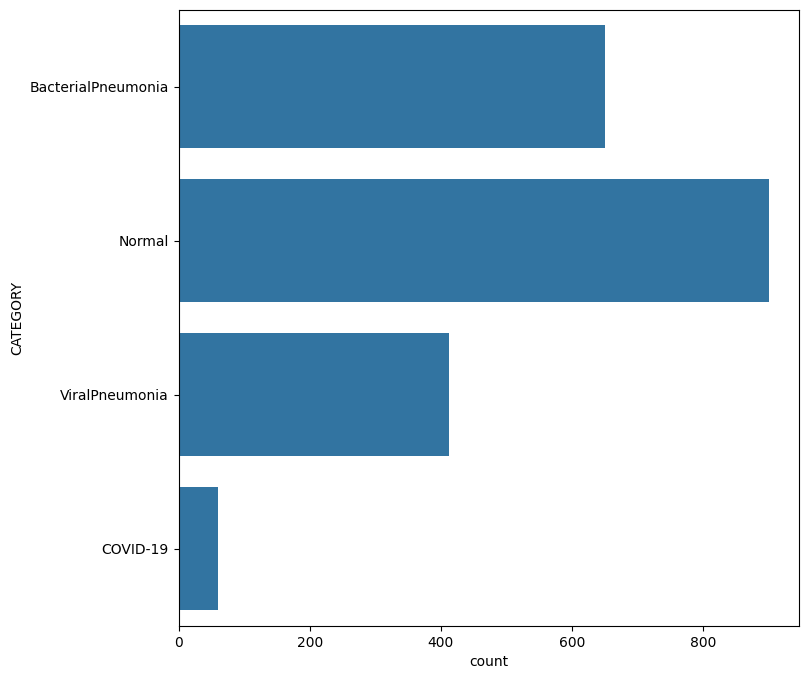

In [19]:
#Visualization
figure = plt.figure(figsize=(8,8))
sns.countplot(Main_Data["CATEGORY"])
plt.show()

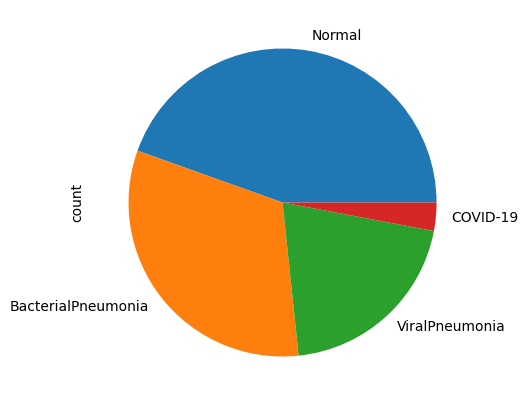

In [20]:
Main_Data['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()

Text(0.5, 1.0, 'BacterialPneumonia')

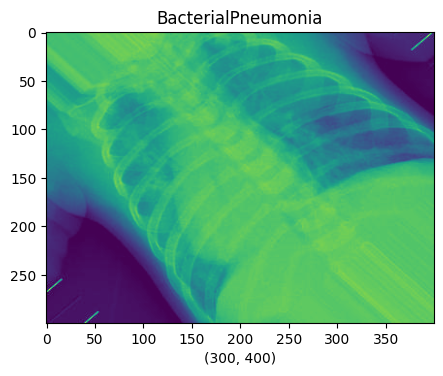

In [21]:
figure = plt.figure(figsize=(5,5))
x = plt.imread(Main_Data["JPG"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Data["CATEGORY"][0])

Text(0.5, 1.0, 'Normal')

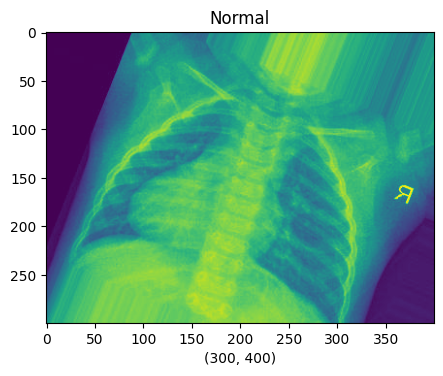

In [22]:
figure = plt.figure(figsize=(5,5))
x = plt.imread(Main_Data["JPG"][1])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(Main_Data["CATEGORY"][1])

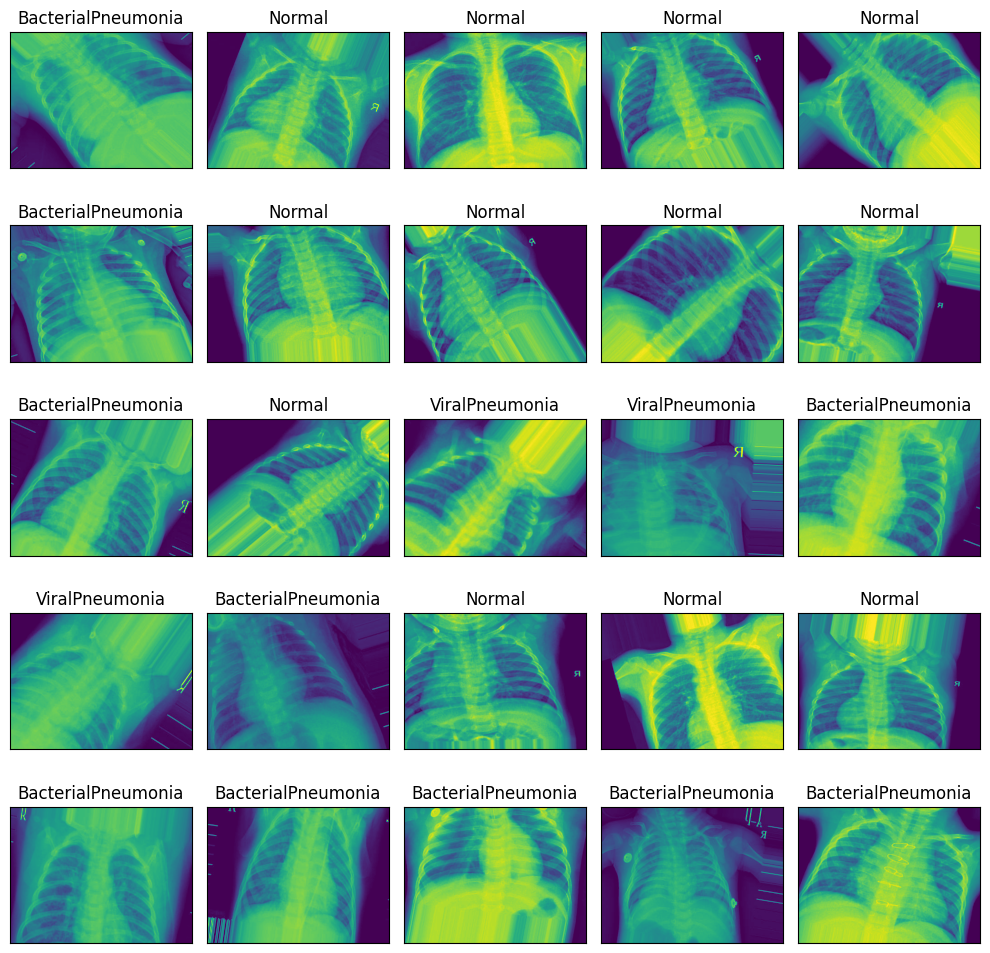

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Data["JPG"][i]))
    ax.set_title(Main_Data["CATEGORY"][i])
plt.tight_layout()
plt.show()

In [24]:
Train_Data,Test_Data = train_test_split(Main_Data,train_size=0.8,random_state=42,shuffle=True)

In [25]:
print(Train_Data.shape)

(1618, 2)


In [26]:
print(Test_Data.shape)

(405, 2)


In [27]:
print(Train_Data.head(-1))

                                                    JPG            CATEGORY
1908  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
1112  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
926   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
261   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
818   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
...                                                 ...                 ...
1095  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
1130  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
1294  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
860   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...      ViralPneumonia
1459  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...      ViralPneumonia

[1617 rows x 2 columns]


In [28]:
print(Test_Data.head(-1))

                                                    JPG            CATEGORY
674   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...      ViralPneumonia
978   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
720   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
590   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
576   C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
...                                                 ...                 ...
1547  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
1596  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...  BacterialPneumonia
1676  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...      ViralPneumonia
1769  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal
1068  C:\Users\karti\Desktop\Projects\DiagnoSphere\D...              Normal

[404 rows x 2 columns]


In [29]:
#Image generator
Generator = ImageDataGenerator(rescale=1./255,
                              validation_split=0.1,
                               horizontal_flip=False,
                               featurewise_center=False,
                                    featurewise_std_normalization=False,
                               rotation_range=20,
                               zoom_range=0.2,
                               shear_range=0.2)

In [65]:
# Example_IMG = Train_Data["JPG"][3]
# IMG = load_img(Example_IMG, target_size=(300, 400))
# Array_IMG = img_to_array(IMG)
# Array_IMG = Array_IMG.reshape((1,) + Array_IMG.shape)

# i = 0
# for BTCH in Generator.flow(Array_IMG,batch_size=1):
#     plt.figure(i)
#     IMG_Plot = plt.imshow(image.array_to_img(BTCH[0]))
#     i += 1
#     if i % 6 == 0:
#         break
# plt.show()

In [31]:
Train_IMG_Set = Generator.flow_from_dataframe(dataframe=Train_Data,
                                             x_col="JPG",
                                             y_col="CATEGORY",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             subset="training",
                                             batch_size=32)

Found 1457 validated image filenames belonging to 4 classes.


In [32]:
Validation_IMG_Set = Generator.flow_from_dataframe(dataframe=Train_Data,
                                             x_col="JPG",
                                             y_col="CATEGORY",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             subset="validation",
                                             batch_size=32)

Found 161 validated image filenames belonging to 4 classes.


In [33]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [34]:
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=Test_Data,
                                             x_col="JPG",
                                             y_col="CATEGORY",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             batch_size=32)

Found 405 validated image filenames belonging to 4 classes.


In [35]:
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 4)


In [36]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 4)


In [37]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 4)


In [38]:
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}
[0, 3, 0, 2, 3]
(256, 256, 3)


In [39]:
print(Validation_IMG_Set.class_indices)
print(Validation_IMG_Set.classes[0:5])
print(Validation_IMG_Set.image_shape)

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}
[2, 2, 2, 0, 2]
(256, 256, 3)


In [40]:
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

{'BacterialPneumonia': 0, 'COVID-19': 1, 'Normal': 2, 'ViralPneumonia': 3}
[3, 0, 2, 0, 0]
(256, 256, 3)


In [41]:
Model = Sequential()

Model.add(Conv2D(32,(5,5),activation="relu",
                 input_shape=(256,256,3),padding="same",strides=(2,2)))
Model.add(MaxPooling2D((2,2)))

#
Model.add(Conv2D(64,(3,3),
                 activation="relu",padding="same",strides=(2,2)))
Model.add(MaxPooling2D((2,2)))

#
Model.add(Conv2D(128,(2,2),
                 activation="relu",padding="same",strides=(2,2)))
Model.add(MaxPooling2D((2,2)))

#
Model.add(Flatten())
Model.add(Dense(256,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(4,activation="softmax"))

In [42]:
Model.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

c:\Users\karti\anaconda3\envs\tf_backup\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [44]:
ANN_Model = Model.fit(
    Train_IMG_Set,
    validation_data=Validation_IMG_Set,
    epochs=60,
    batch_size=5,
    callbacks=[checkpoint,early_stopping]
)

Epoch 1/60
46/46 [==============================] - 25s 356ms/step - loss: 1.1941 - accuracy: 0.4386 - val_loss: 1.2479 - val_accuracy: 0.2671
Epoch 2/60
46/46 [==============================] - 13s 271ms/step - loss: 1.0273 - accuracy: 0.5683 - val_loss: 0.8469 - val_accuracy: 0.6522
Epoch 3/60
46/46 [==============================] - 12s 247ms/step - loss: 0.9004 - accuracy: 0.6253 - val_loss: 0.7647 - val_accuracy: 0.6584
Epoch 4/60
46/46 [==============================] - 11s 246ms/step - loss: 0.8884 - accuracy: 0.6342 - val_loss: 0.8146 - val_accuracy: 0.6708
Epoch 5/60
46/46 [==============================] - 12s 267ms/step - loss: 0.8774 - accuracy: 0.6452 - val_loss: 0.7341 - val_accuracy: 0.7329
Epoch 6/60
46/46 [==============================] - 12s 250ms/step - loss: 0.8447 - accuracy: 0.6582 - val_loss: 0.7089 - val_accuracy: 0.7267
Epoch 7/60
46/46 [==============================] - 12s 261ms/step - loss: 0.8150 - accuracy: 0.6637 - val_loss: 0.6502 - val_accuracy: 0.7391

In [45]:
Model_Results = Model.evaluate(Test_IMG_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

LOSS:  0.7074
ACCURACY:  0.71


In [46]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

C:\Users\karti\AppData\Local\Temp\ipykernel_7624\4037994353.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


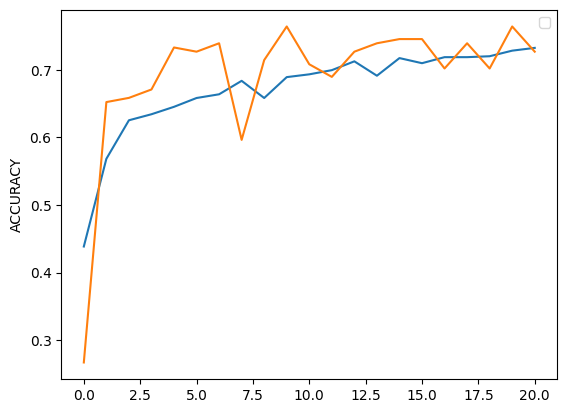

In [47]:
plt.plot(ANN_Model.history["accuracy"])
plt.plot(ANN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

In [48]:
HistoryDict = ANN_Model.history

val_losses = HistoryDict["val_loss"]
val_acc = HistoryDict["val_accuracy"]
acc = HistoryDict["accuracy"]
losses = HistoryDict["loss"]
epochs = range(1,len(val_losses)+1)

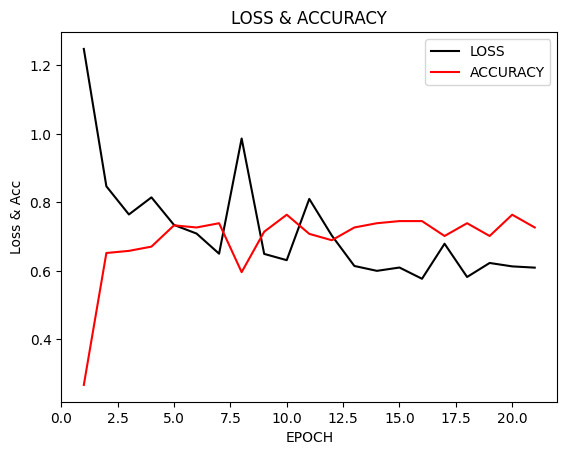

In [49]:
plt.plot(epochs,val_losses,"k-",label="LOSS")
plt.plot(epochs,val_acc,"r",label="ACCURACY")
plt.title("LOSS & ACCURACY")
plt.xlabel("EPOCH")
plt.ylabel("Loss & Acc")
plt.legend()
plt.show()

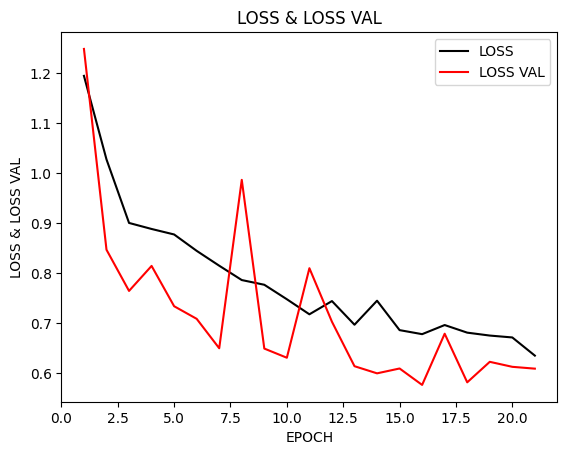

In [50]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"r",label="LOSS VAL")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

In [51]:
Model_Test_Prediction = Model.predict(Test_IMG_Set)

13/13 [==============================] - 1s 54ms/step


In [52]:
Model_Test_Prediction = Model_Test_Prediction.argmax(axis=-1)

In [53]:
print(Model_Test_Prediction)

[0 0 0 0 2 0 0 0 3 2 0 0 0 2 2 0 2 0 2 2 0 0 0 0 0 0 0 0 0 2 2 2 0 2 0 1 2
 0 2 0 2 2 3 0 2 0 0 2 0 2 2 2 0 2 0 0 0 2 2 0 0 0 2 0 0 2 0 0 0 2 0 0 2 2
 0 0 3 0 2 2 0 0 0 0 2 2 2 2 2 2 0 0 2 2 2 2 2 3 2 0 2 2 0 0 2 2 2 2 0 3 0
 2 2 2 2 0 0 2 0 2 0 0 0 2 2 2 0 3 2 0 0 2 0 0 0 0 2 3 2 2 2 0 2 0 2 2 2 0
 3 2 0 2 0 0 2 0 0 2 2 2 0 0 2 2 0 2 0 0 0 0 2 2 3 2 2 0 0 0 0 2 2 2 0 2 0
 2 2 0 0 0 2 0 0 2 3 2 0 0 0 0 0 2 3 0 2 0 0 2 0 0 2 0 2 2 3 0 0 2 2 2 0 0
 0 0 2 2 0 0 0 0 0 0 2 0 2 0 0 2 0 0 2 2 2 2 0 2 0 2 3 2 2 2 0 2 2 0 0 2 0
 2 2 0 2 0 2 0 2 0 0 0 2 2 0 0 0 0 0 2 2 2 0 3 0 2 2 2 2 0 2 0 2 3 0 2 1 2
 2 0 1 2 0 3 0 0 2 2 0 2 0 0 0 0 2 0 0 2 2 0 0 0 2 0 0 2 2 0 0 2 0 0 2 0 3
 2 2 0 2 0 0 0 3 2 0 0 0 3 2 0 2 2 2 2 0 2 2 2 0 0 0 2 0 0 0 2 2 0 0 0 2 2
 0 0 2 2 0 0 0 3 2 2 2 0 2 2 2 2 0 0 2 2 0 0 2 2 2 2 0 0 0 2 2 0 2 0 0]


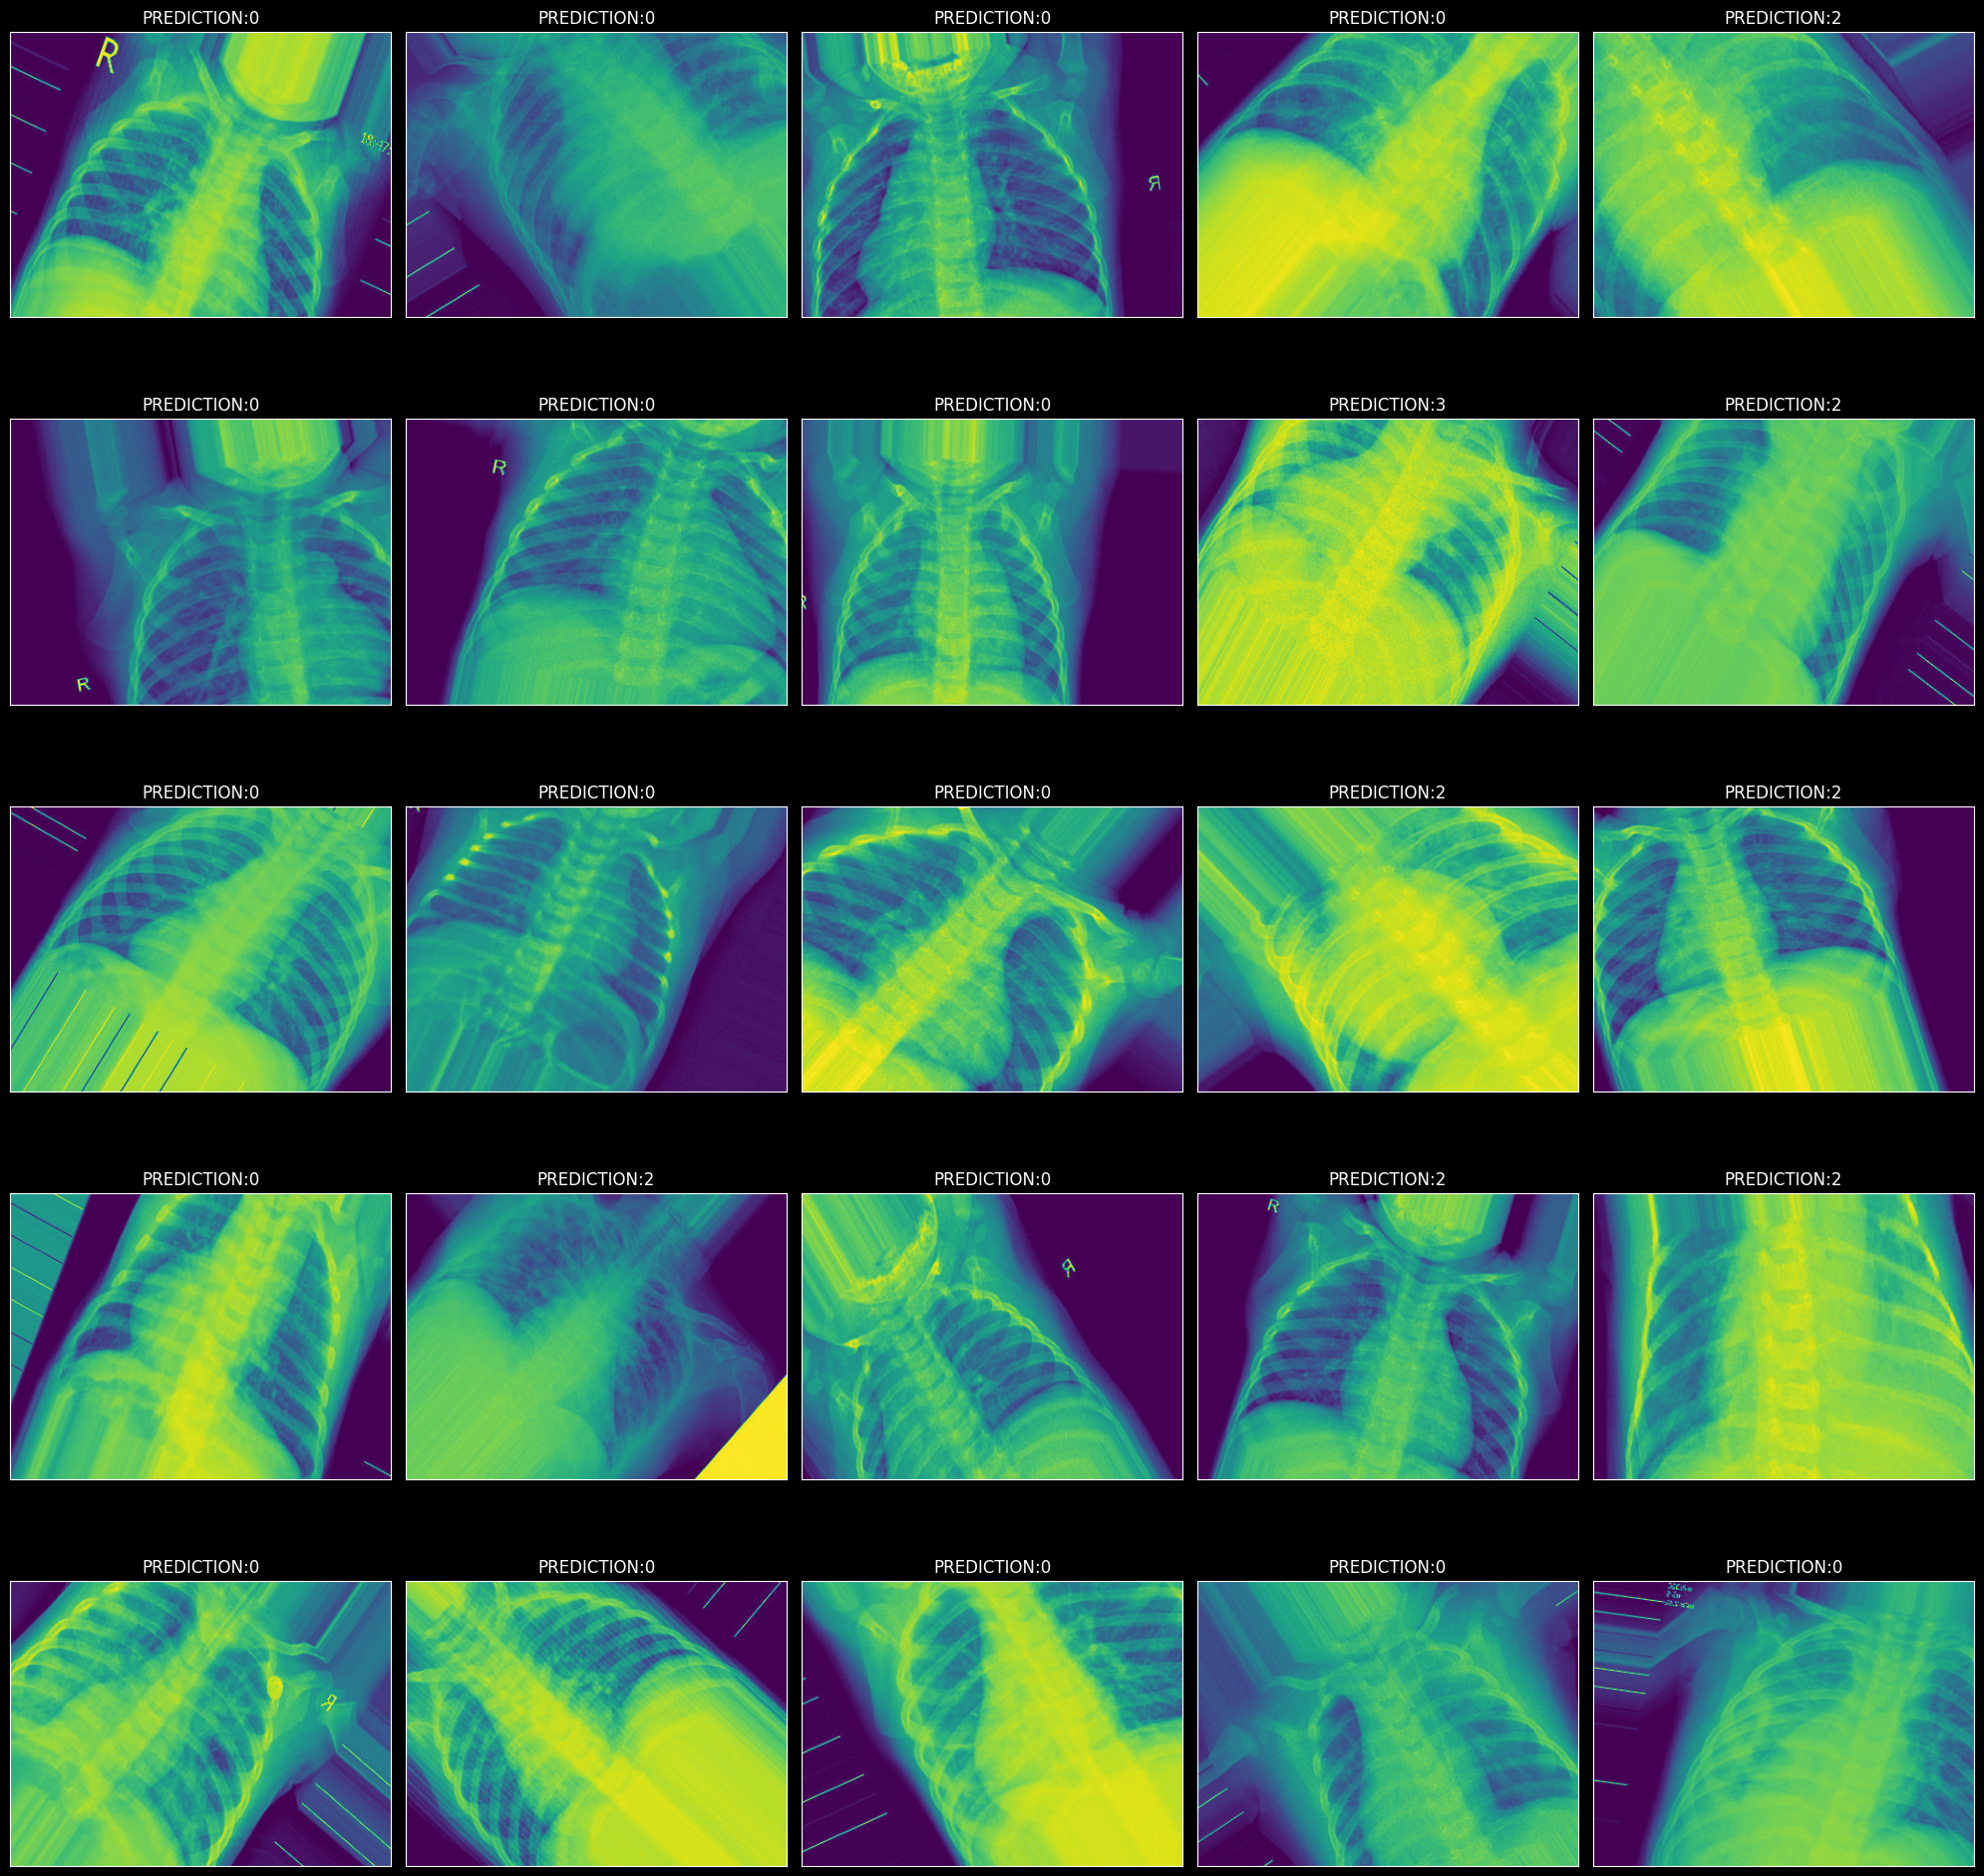

In [54]:
plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Test_Data["JPG"].iloc[i]))
    ax.set_title(f"PREDICTION:{Model_Test_Prediction[i]}")
plt.tight_layout()
plt.show()

In [59]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

Any_IMG = Train_Data["JPG"][6]
IMG = load_img(Any_IMG, target_size=(256, 256))
Array_IMG = img_to_array(IMG)
Array_IMG = np.expand_dims(Array_IMG, axis=0)
Array_IMG /= 255.0  # Ensure correct scaling

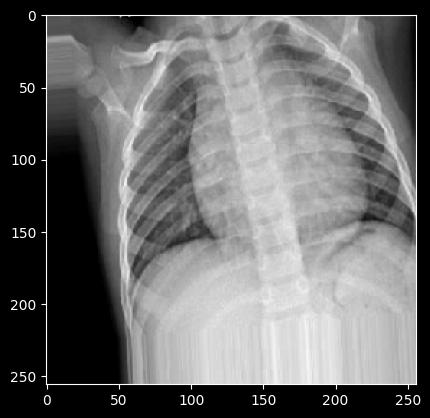

In [60]:
plt.imshow(Array_IMG[0])
plt.show()

In [61]:
layer_out = [layer.output for layer in Model.layers[:8]]

In [62]:
activation_model = models.Model(inputs=Model.input,outputs=layer_out)

In [63]:
activations = activation_model.predict(Array_IMG)

1/1 [==============================] - 0s 118ms/step
